In [1]:
############################ PREPARATION ############################

#-------------------------- import packages --------------------------
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from itertools import combinations, product
import pyreadr
import seaborn as sns
import copy
import math

import tensorflow as tf
import tensorflow_lattice as tfl
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Multiply, Add, Embedding, Reshape, Concatenate, Dropout, BatchNormalization, Lambda, Layer, CategoryEncoding, Activation
from keras.constraints import Constraint
from keras.callbacks import EarlyStopping
from keras.initializers import Zeros, Constant
from keras.optimizers.legacy import Adam, Nadam, RMSprop
from keras.models import clone_model
import keras_tuner as kt
from keras import backend as K
from keras import regularizers
from keras.utils import plot_model
from keras.losses import Poisson, Loss
from keras.metrics import MeanAbsoluteError, RootMeanSquaredError

# import xgboost as xgb
from scipy.stats import uniform, randint
from pygam import PoissonGAM, GAM, s, f, l, te # s for spline, f for factor, l for linear, te for tensor product
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import make_scorer
from interpret.glassbox import ExplainableBoostingRegressor
import joblib

import warnings
warnings.filterwarnings('ignore') # suprress warnings

In [2]:
#-------------------------- for reproducibility --------------------------
seed_value = 2000
keras.utils.set_random_seed(seed_value)
np.random.seed(seed_value)

In [3]:
#-------------------------- import data --------------------------
''' Belgian motor third-party liability dataset from the CAS collection '''
r_data = pyreadr.read_r("data/beMTPL97.rda")
data = r_data['beMTPL97']
data.head() # view data snapshot

,id,expo,claim,nclaims,amount,average,coverage,ageph,sex,bm,power,agec,fuel,use,fleet,postcode,long,lat
0,1,1.000000,1,1,1618.001036,1618.001036,TPL,50,male,5,77,12,gasoline,private,0,1000,4.355223,50.845386
1,2,1.000000,0,0,0.000000,NaN,TPL+,64,female,5,66,3,gasoline,private,0,1000,4.355223,50.845386
2,3,1.000000,0,0,0.000000,NaN,TPL,60,male,0,70,10,diesel,private,0,1000,4.355223,50.845386
3,4,1.000000,0,0,0.000000,NaN,TPL,77,male,0,57,15,gasoline,private,0,1000,4.355223,50.845386
4,5,0.046575,1,1,155.974606,155.974606,TPL,28,female,9,70,7,gasoline,private,0,1000,4.355223,50.845386


In [4]:
############################ CUSTOM FUNCTIONS ############################

# -------------------------- custom layer and subnetwork --------------------------
# subnetwork for numerical variables
def create_subnet(num_layers, units_first_layer, activation, model_name, dropout_rate = 0, trainable = True, seed = 1):
    model = Sequential(name = model_name)
    for i in range(num_layers):
        num_units = units_first_layer - i*int(units_first_layer/num_layers)
        model.add(Dense(num_units, activation = activation, trainable = trainable))
        model.add(Dropout(dropout_rate, seed = seed))
    model.add(Dense(1, trainable = trainable))
    model.add(BatchNormalization(scale = False)) # for identifiability
    return model

# layer to add all subnets' outputs and a bias term
@keras.saving.register_keras_serializable()
class AddSubnetOutput(Layer):
    def __init__(self, activation = None, **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.bias = self.add_weight(
            shape = (1,), initializer = 'zeros', trainable = True, name = 'bias'
        )   
    def call(self, inputs):
        subnet_sum = K.sum(inputs, axis = -1, keepdims = True)
        output = subnet_sum + self.bias
        if self.activation is not None:
            output = self.activation(output)
        return output

# helper function to add calibrator layer
def add_calibrate_layer(var, other_var, data, monotonicity_list, lattice_sizes, keypoints, cat_vars, all_vars, lattice_smooth_reg = [0,0]):
    if var in cat_vars:
        calibrator_layer = tfl.layers.CategoricalCalibration(
            num_buckets = np.unique(data[:,all_vars.index(var)]).size,
            output_min = 0,
            output_max = lattice_sizes[var] - 1
            # name = f"{var}_calibrator_pairwise_{var}_{other_var}"
        )
    else:
        calibrator_layer = tfl.layers.PWLCalibration(
            input_keypoints =  np.linspace(data[:,all_vars.index(var)].min(), data[:,all_vars.index(var)].max(), num = keypoints), # keypoints
            kernel_regularizer = ('hessian', lattice_smooth_reg[0], lattice_smooth_reg[1]), # for smoothness
            monotonicity = monotonicity_list[var] if var in monotonicity_list else "none", # monotonicity constraint
            output_min = 0,
            output_max = lattice_sizes[var] - 1
            # name = f"{var}_calibrator_pairwise_{var}_{other_var}"
            )
    return calibrator_layer

In [5]:
# -------------------------- custom constraint--------------------------
# function to add smoothness penalty
def make_smoothness_penalty(var, data, model, lambd_smooth, grid_length, imp_vars, all_vars):
    # Create input grid as TensorFlow tensors
    grid_min = tf.constant(data[:,all_vars.index(var)].min(), dtype = tf.float32)
    grid_max = tf.constant(data[:,all_vars.index(var)].max(), dtype = tf.float32)
    grid = tf.linspace(grid_min, grid_max, grid_length)
    grid = tf.reshape(grid, (-1, 1))  # Ensure grid is a column vector

    # Prepare inputs for the model
    grid_inputs = []
    for feature in imp_vars:
        if feature == var:
            grid_inputs.append(grid)
        else:
            # Use zeros_like to match the shape of grid
            grid_inputs.append(tf.zeros_like(grid))

    # Define a zero-argument function to compute the penalty
    def smoothness_penalty():
        # Get the prediction
        f = model(grid_inputs)
        lam = f[:, 0]
        pi = f[:, 1]
        mean = (1 - pi)*lam
        variance = (1 - pi) * lam * (1 + pi * lam)

        h = (grid_max - grid_min) / (grid_length - 1)
        h_squared = h ** 2
        # For mean
        mean_plus = mean[2:]      # f(x + h)
        mean_minus = mean[:-2]    # f(x - h)
        mean_current = mean[1:-1] # f(x)
        # For variance
        var_plus = variance[2:]      # f(x + h)
        var_minus = variance[:-2]    # f(x - h)
        var_current = variance[1:-1] # f(x)

        # Second derivative approximation
        secdev_mean = (mean_plus + mean_minus - 2 * mean_current) / h_squared
        secdev_var = (var_plus + var_minus - 2 * var_current) / h_squared

        # Compute the penalty
        penalty = lambd_smooth * (
            K.mean(K.abs(secdev_mean)) + 
            K.mean(K.abs(secdev_var))
        )
        return penalty
    
    return smoothness_penalty

In [6]:
# -------------------------- Zero-inflated Poisson Negative Log-likelihood (NLL) --------------------------
def zip_loss(y_true, y_pred):

    """
    y_pred is assumed to have two columns:
      - Column 0: λ (Poisson mean)
      - Column 1: π (zero-inflation probability, in (0,1))
    """
    # Cast y_true to float32 for numerical operations using the Keras backend
    y_true = K.cast(y_true, 'float32')
    
    # Extract parameters
    eps = K.epsilon()
    lambda_ = K.maximum(y_pred[:, 0], eps)
    pi = K.clip(y_pred[:, 1], eps, 1 - eps) # pi will not become exactly 0 or 1
    
    # Indicator for zero observations
    is_zero = K.cast(K.equal(y_true, 0), 'float32')
    
    # Calculate NLL
    loglik_zero = K.log(pi + (1 - pi) * K.exp(-lambda_)) # log-likelihood for zero
    loglik_count = K.log(1 - pi) - lambda_ + y_true * K.log(lambda_) - tf.math.lgamma(y_true + 1) # log-likehood for positive
    loglik = is_zero * loglik_zero + (1 - is_zero) * loglik_count # log-likelihood
    return K.mean(-loglik)

In [7]:
# -------------------------- Zero-inflated Poisson CRPS --------------------------
def zip_crps(y_true, y_pred):

    # Cast y_true to float32 for numerical operations using the Keras backend
    y_true = K.cast(y_true, 'float32')
    
    # Extract parameters
    eps = K.epsilon()
    lambda_ = K.maximum(y_pred[:, 0], eps)
    pi = K.clip(y_pred[:, 1], eps, 1 - eps) # pi will not become exactly 0 or 1

    # Choose the truncation for CRPS
    max_y = K.cast(K.max(y_true), 'int32') + 100 # maximum value for CRPS
    y_range = K.arange(max_y + 1, dtype='float32')

    # PMF and CDF
    lambda_ = K.expand_dims(lambda_, 1)
    y_range = K.expand_dims(y_range, 0)
    log_pmf = -lambda_ + y_range * K.log(lambda_) - tf.math.lgamma(y_range + 1.)
    pmf = K.exp(log_pmf)
    cdf_pois = K.cumsum(pmf, axis = 1)
    F_k = pi[:, None] + (1. - pi)[:, None] * cdf_pois # CDF for ZIP

    # CRPS calculation
    ind = K.cast(y_range >= K.expand_dims(y_true, 1), 'float32') # indicator
    crps = K.sum(K.square(F_k - ind), axis = 1)
    return K.mean(crps)

In [8]:
############################ DATA UNDERSTANDING & CLEANING ############################

#-------------------------- high-level checking --------------------------
print(data.shape) # number of rows and columns
print(data.info()) # check data type and missing values

(163212, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163212 entries, 0 to 163211
Data columns (total 18 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   id        163212 non-null  int32   
 1   expo      163212 non-null  float64 
 2   claim     163212 non-null  category
 3   nclaims   163212 non-null  int32   
 4   amount    163212 non-null  float64 
 5   average   18276 non-null   float64 
 6   coverage  163212 non-null  category
 7   ageph     163212 non-null  int32   
 8   sex       163212 non-null  category
 9   bm        163212 non-null  int32   
 10  power     163212 non-null  int32   
 11  agec      163212 non-null  int32   
 12  fuel      163212 non-null  category
 13  use       163212 non-null  category
 14  fleet     163212 non-null  category
 15  postcode  163212 non-null  int32   
 16  long      163212 non-null  float64 
 17  lat       163212 non-null  float64 
dtypes: category(6), float64(5), int32(7)
memory usage: 

In [9]:
#-------------------------- filter claim data --------------------------
claim = data.drop(columns = ["id","claim","amount","average","postcode"]).reset_index(drop = True) # filter positive claims and remove unnecessary columns
print(f"{claim.shape[0]} rows and {claim.shape[1]} columns")
claim.head()

163212 rows and 13 columns


,expo,nclaims,coverage,ageph,sex,bm,power,agec,fuel,use,fleet,long,lat
0,1.000000,1,TPL,50,male,5,77,12,gasoline,private,0,4.355223,50.845386
1,1.000000,0,TPL+,64,female,5,66,3,gasoline,private,0,4.355223,50.845386
2,1.000000,0,TPL,60,male,0,70,10,diesel,private,0,4.355223,50.845386
3,1.000000,0,TPL,77,male,0,57,15,gasoline,private,0,4.355223,50.845386
4,0.046575,1,TPL,28,female,9,70,7,gasoline,private,0,4.355223,50.845386


In [10]:
#-------------------------- descriptive statistics for numeric columns --------------------------
claim[["expo","nclaims","ageph","bm","power","agec","long","lat"]].describe()

,expo,nclaims,ageph,bm,power,agec,long,lat
count,163212.000000,163212.000000,163212.000000,163212.000000,163212.000000,163212.000000,163212.000000,163212.000000
mean,0.889744,0.123857,47.000950,3.268246,56.002978,7.374923,4.407262,50.758422
std,0.244202,0.367471,14.831561,3.998171,19.024828,4.206447,0.751036,0.317856
min,0.002740,0.000000,18.000000,0.000000,10.000000,0.000000,2.577787,49.536246
25%,1.000000,0.000000,35.000000,0.000000,43.000000,4.000000,3.879313,50.516333
50%,1.000000,0.000000,46.000000,1.000000,53.000000,7.000000,4.387146,50.771932
75%,1.000000,0.000000,58.000000,6.000000,66.000000,10.000000,4.874195,50.994654
max,1.000000,5.000000,95.000000,22.000000,243.000000,48.000000,6.305543,51.449816


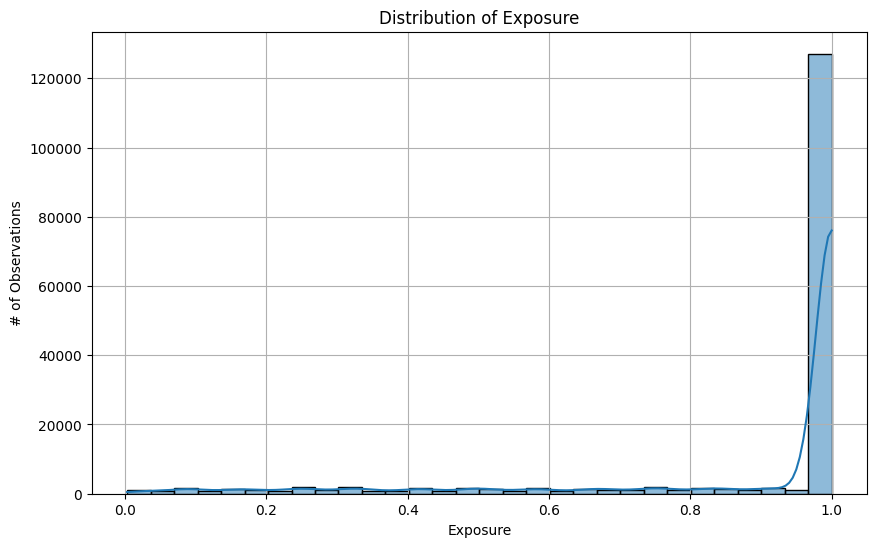

In [11]:
#-------------------------- distribution of claim amount --------------------------
plt.figure(figsize = (10, 6)) # set the size of the figure
sns.histplot(claim['expo'], bins = 30, kde = True) # draw the chart
plt.title('Distribution of Exposure')
plt.xlabel('Exposure')
plt.ylabel('# of Observations')
plt.grid(True)
plt.show()

In [12]:
### function to get the summary of number of instances per distinct category for categorical variable
def get_summary(data, column):
    summary = data[column].value_counts().reset_index()
    summary.columns = [column, 'Count']
    return summary

In [13]:
#-------------------------- check the distribution of categorical variables --------------------------
# get the categorical variables
cat_vars = ["coverage", "sex", "fuel", "use", "fleet"]
num_vars = ["ageph", "bm", "power", "agec", "long", "lat"] # numerical variables
all_vars = ["expo"] + cat_vars + num_vars

# get the distributions of categorical and target variables
summary_tables = {}
for column in ["nclaims"] + cat_vars:
    summary = get_summary(claim, column)
    summary_tables[column] = summary

# display the summary tables
for column, summary in summary_tables.items():
    print(f"{column} Summary:\n", summary, "\n")

nclaims Summary:
    nclaims   Count
0        0  144936
1        1   16539
2        2    1556
3        3     162
4        4      17
5        5       2 

coverage Summary:
   coverage  Count
0      TPL  95124
1     TPL+  45984
2    TPL++  22104 

sex Summary:
       sex   Count
0    male  120044
1  female   43168 

fuel Summary:
        fuel   Count
0  gasoline  112818
1    diesel   50394 

use Summary:
        use   Count
0  private  155334
1     work    7878 

fleet Summary:
   fleet   Count
0     0  158041
1     1    5171 



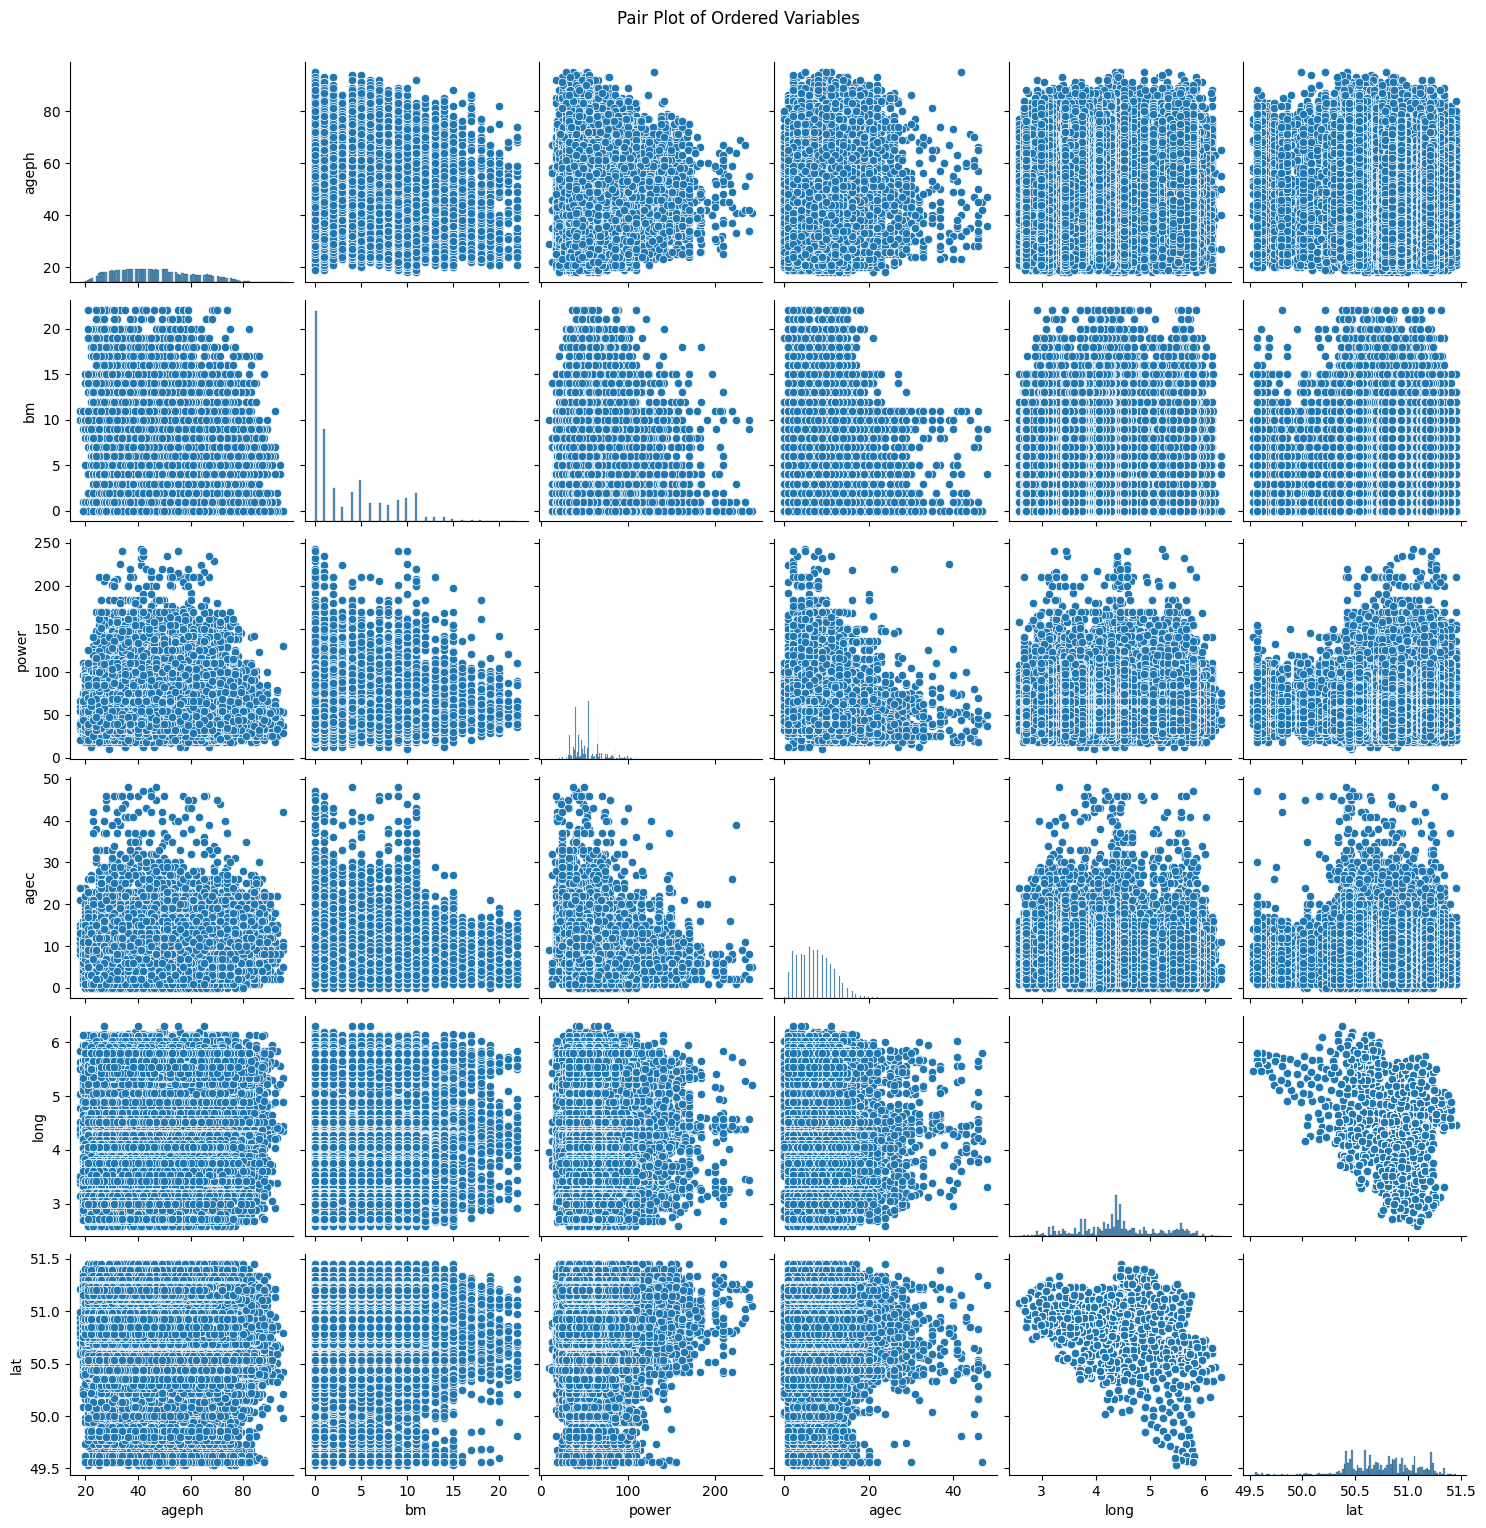

In [14]:
# -------------------------- check distribution of continuous and ordinal variables --------------------------
# Create pair plots for the specified variables
sns.pairplot(claim[num_vars])
plt.suptitle('Pair Plot of Ordered Variables', y = 1.02)
plt.show()

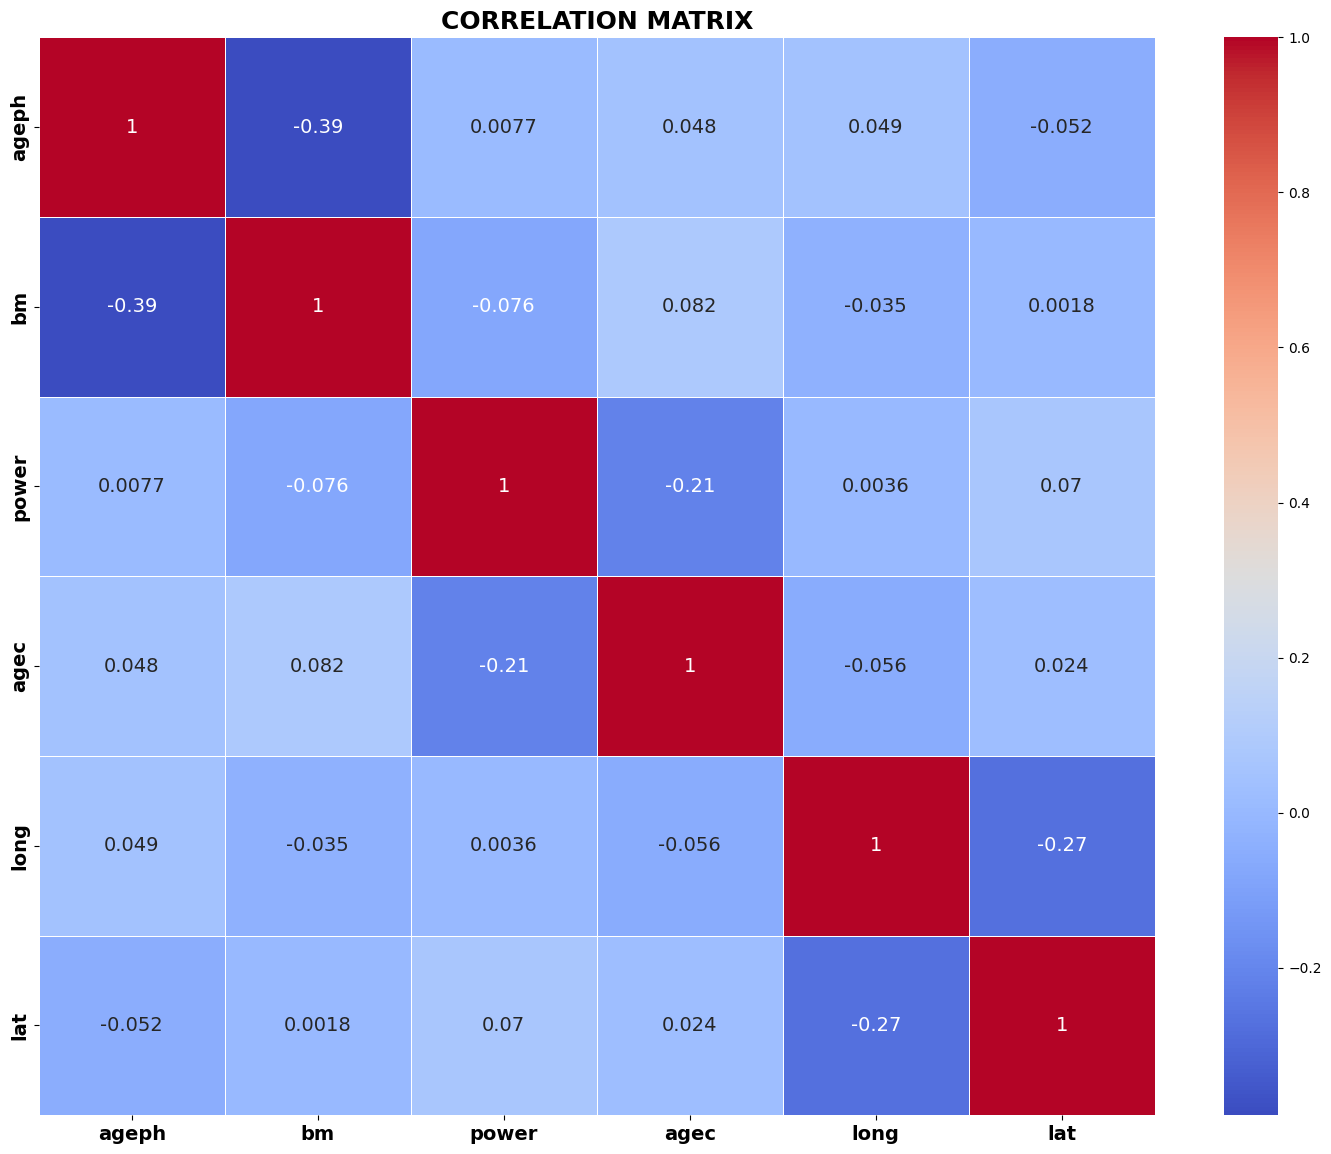

In [15]:
#-------------------------- check correlations of numeric variables --------------------------
correlation_matrix = claim[num_vars].corr() # correlation matrix

# plot the heatmap
plt.figure(figsize = (18, 14))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', linewidths = 0.5, annot_kws = {"size":14})
plt.title('CORRELATION MATRIX', fontsize = 18, fontweight = 'bold')
plt.xticks(fontsize = 14, fontweight = 'bold')
plt.yticks(fontsize = 14, fontweight = 'bold')
plt.show()

In [16]:
#-------------------------- train-test split --------------------------
target_var = "nclaims"
X_main, X_test, y_main, y_test = train_test_split(
    claim[all_vars], claim[target_var], test_size = 0.2, random_state = 1)
X_train, X_val, y_train, y_val  = train_test_split(
    X_main, y_main, test_size = 0.25, random_state = 1)

In [17]:
#-------------------------- variable encoding --------------------------
# define transformer
ct = make_column_transformer(
    ("passthrough", ["expo"]),
    (OrdinalEncoder(), cat_vars),
    remainder = StandardScaler(),
    verbose_feature_names_out = False
)

# fit & transform
train = ct.fit_transform(X_train)
val = ct.fit_transform(X_val)
test = ct.transform(X_test)
feature_names = ct.get_feature_names_out()  # get the columns' names
feature_names

array(['expo', 'coverage', 'sex', 'fuel', 'use', 'fleet', 'ageph', 'bm',
       'power', 'agec', 'long', 'lat'], dtype=object)

In [18]:
############################ NEURAL ADDITIVE MODEL ############################
#-------------------------- prepare the data for NAM --------------------------
X_train_split = []
X_val_split = []
for i in range(train.shape[1]):
    X_train_split.append(train[:, i])
    X_val_split.append(val[:, i])

In [19]:
# -------------------------- Fit an ensemble of 10 NAMs --------------------------
seed = 0
num_models = 10
all_variance = []

# create ensemble and get subnet variance
for i in range(num_models):
    
    keras.utils.set_random_seed(seed)

    # -------------------------- hyperparameters --------------------------
    inputs = []  # input layers
    sub_outputs_main = []  # main effect subnet output
    num_neurons_main = 20
    num_layers_main = 2
    activation = 'leaky_relu'
    keypoints = 10
    monotonicity_list = {"bm" : "increasing"} # either "increasing", "decreasing", or "none"


    # -------------------------- model architecture --------------------------
    # main effect
    for name in all_vars:
        input_layer = Input(shape = (1,), name = name)
        inputs.append(input_layer)

        # subnetworks for main effects
        if name == "expo":  # Direct use without a subnet
            exposure_input = input_layer
        elif name in cat_vars: # categorical variables
            # categorical variables will be one-hot encoded
            embed_layer = Embedding(input_dim = X_train[name].nunique(), 
                                    output_dim = 1, 
                                    name = f"{name}_embed")(input_layer)
            embed_layer_reshape = Reshape(target_shape = (1,), name = f"{name}_reshape")(embed_layer)
            mean_layer = BatchNormalization(scale = False, name = f"{name}_mean")(embed_layer_reshape)
            sub_outputs_main.append(mean_layer)
        elif name in monotonicity_list: # variables with monotonicity constraint
            calibrator_layer = tfl.layers.PWLCalibration(
                input_keypoints =  np.linspace(train[:,all_vars.index(name)].min(), train[:,all_vars.index(name)].max(), num = keypoints), # keypoints
                monotonicity = monotonicity_list[name], # monotonicity constraint
                name = f"{name}_pwlcalibrator"
            )(input_layer)
            mean_layer = BatchNormalization(scale = False, name = f"{name}_mean")(calibrator_layer)
            sub_outputs_main.append(mean_layer)
        else: # numeric variables
            subnet = create_subnet(num_layers_main, num_neurons_main, activation, f"{name}_subnetwork")
            sub_output = subnet(input_layer)
            sub_outputs_main.append(sub_output)

    # combine subnets' outputs
    main_subnets = Concatenate(name = "main_subnet")(sub_outputs_main)
    sum_output = AddSubnetOutput(activation = 'exponential',
                        name = "main_output")(main_subnets) # claim frequency per unit of exposure
    final_output = Multiply(name = "final_output")([exposure_input, sum_output])

    # model
    model_all_vars = Model(inputs = inputs, outputs = final_output)


    # -------------------------- fit the model --------------------------
    model_all_vars.compile(optimizer = "rmsprop", loss = "poisson", metrics = ["poisson", RootMeanSquaredError(), MeanAbsoluteError()])
    es = EarlyStopping(restore_best_weights = True, patience = 10)
    model_all_vars.fit(X_train_split, y_train, epochs = 5_000, \
        callbacks = [es], batch_size = 5_000, validation_data = (X_val_split, y_val), verbose = 0)
    

    # -------------------------- quantify variable importance --------------------------
    main_output_layer = model_all_vars.get_layer("main_subnet")  # Get the subnet output layer
    main_model = Model(inputs = model_all_vars.inputs, outputs = main_output_layer.output)
    main_output_values = main_model.predict(X_train_split, batch_size = 5_000)

    # Get the variance of each subnetwork across all data points
    subnet_variance = [np.var(main_output_values[:, i]) for i in range(main_output_values.shape[1])]
    all_variance.append(subnet_variance)

    # update seed
    seed += 1

20/20 [==============================] - 0s 2ms/step


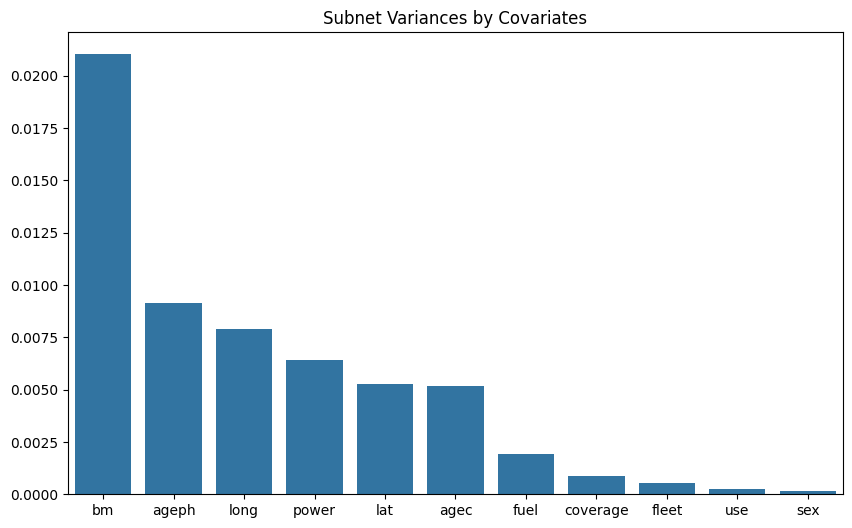

In [20]:
# -------------------------- plot the variable importance --------------------------
average_variances = np.mean(all_variance, axis = 0) # get the average variance
covariates = [name for name in cat_vars + num_vars] # get variable name

# Create DataFrame for variable importance
var_importance = pd.DataFrame({"Covariates": covariates, "Subnet Variance": average_variances})

# Sort the DataFrame by subnet variance in decreasing order
varimp_sorted = var_importance.sort_values(by = "Subnet Variance", ascending = False)

# Create a bar plot using Seaborn
plt.figure(figsize = (10, 6))
sns.barplot(x = "Covariates", y = "Subnet Variance", data = varimp_sorted)
plt.title("Subnet Variances by Covariates")
plt.xlabel("")
plt.ylabel("")

# plt.rcParams["figure.figsize"] = (14, 6) # (for square figures)
# plt.rcParams["figure.dpi"] = 350
# plt.rcParams["savefig.bbox"] = "tight"
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["axes.spines.right"] = False
# plt.rcParams["axes.spines.top"] = False

plt.show()

In [21]:
#-------------------------- reset keras seed --------------------------
keras.utils.set_random_seed(seed_value)

In [22]:
#-------------------------- main effect model --------------------------
inputs = []  # input layers
sub_outputs_main = []  # main effect subnet output
num_neurons_main = 20
num_layers_main = 2
activation = 'leaky_relu'
keypoints = 10
monotonicity_list = {"bm" : "increasing"} # either "increasing", "decreasing", or "none"
imp_vars = ["ageph", "bm", "power", "lat", "long", "fuel", "agec"]

# main effect
for name in ["expo"] + imp_vars:
    input_layer = Input(shape = (1,), name = name)
    inputs.append(input_layer)

    # subnetworks for main effects
    if name == "expo":  # Direct use without a subnet
        exposure_input = input_layer
    elif name in cat_vars: # categorical variables
        # categorical variables will be one-hot encoded
        embed_layer = Embedding(input_dim = X_train[name].nunique(), 
                                output_dim = 1, 
                                name = f"{name}_embed")(input_layer)
        embed_layer_reshape = Reshape(target_shape = (1,), name = f"{name}_reshape")(embed_layer)
        mean_layer = BatchNormalization(scale = False, name = f"{name}_mean")(embed_layer_reshape)
        sub_outputs_main.append(mean_layer)
    elif name in monotonicity_list: # variables with monotonicity constraint
        calibrator_layer = tfl.layers.PWLCalibration(
            input_keypoints =  np.linspace(train[:,all_vars.index(name)].min(), train[:,all_vars.index(name)].max(), num = keypoints), # keypoints
            monotonicity = monotonicity_list[name], # monotonicity constraint
            name = f"{name}_pwlcalibrator"
        )(input_layer)
        mean_layer = BatchNormalization(scale = False, name = f"{name}_mean")(calibrator_layer)
        sub_outputs_main.append(mean_layer)
    else: # numeric variables
        subnet = create_subnet(num_layers_main, num_neurons_main, activation, f"{name}_subnetwork")
        sub_output = subnet(input_layer)
        sub_outputs_main.append(sub_output)

# combine subnets' outputs
main_subnets = Concatenate(name = "main_subnet")(sub_outputs_main)
sum_output = AddSubnetOutput(activation = 'exponential',
                    name = "main_effect_sum")(main_subnets) # claim frequency per unit of exposure
final_output = Multiply(name = "main_effect_output")([exposure_input, sum_output])

# model
model_main_effect = Model(inputs = inputs, outputs = final_output)

In [23]:
#-------------------------- data preparation --------------------------
X_train_split = []
X_val_split = []
X_test_split = []
for var in ["expo"] + imp_vars:
    X_train_split.append(train[:, all_vars.index(var)])
    X_val_split.append(val[:, all_vars.index(var)])
    X_test_split.append(test[:, all_vars.index(var)])

In [24]:
# #-------------------------- fit NAM with only important main effects --------------------------
model_main_effect.compile(optimizer = "rmsprop", loss = "poisson")
es = EarlyStopping(restore_best_weights = True, patience = 20)
model_main_effect.fit(X_train_split, y_train, epochs = 5_000, \
    callbacks = [es], batch_size = 5_000, validation_data = (X_val_split, y_val))

Epoch 1/5000
20/20 [==============================] - 1s 12ms/step - loss: 3.4578 - val_loss: 0.6088
Epoch 2/5000
20/20 [==============================] - 0s 5ms/step - loss: 1.7324 - val_loss: 0.6077
Epoch 3/5000
20/20 [==============================] - 0s 4ms/step - loss: 1.2285 - val_loss: 0.6028
Epoch 4/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.9301 - val_loss: 0.5869
Epoch 5/5000
20/20 [==============================] - 0s 5ms/step - loss: 0.6707 - val_loss: 0.5332
Epoch 6/5000
20/20 [==============================] - 0s 7ms/step - loss: 0.5795 - val_loss: 0.4837
Epoch 7/5000
20/20 [==============================] - 0s 7ms/step - loss: 0.5302 - val_loss: 0.4482
Epoch 8/5000
20/20 [==============================] - 0s 7ms/step - loss: 0.4881 - val_loss: 0.4285
Epoch 9/5000
20/20 [==============================] - 0s 7ms/step - loss: 0.4617 - val_loss: 0.4070
Epoch 10/5000
20/20 [==============================] - 0s 7ms/step - loss: 0.4331 - val_loss: 0.394

In [25]:
# -------------------------- get validation loss --------------------------
main_val_loss = model_main_effect.evaluate(X_val_split, y_val, verbose = False) # get the validation loss and RMSE
print(f"Validation loss for main effect: {main_val_loss}")

Validation loss for main effect: 0.372553288936615


In [26]:
#-------------------------- preparation for interaction selection --------------------------
global_layers = ["main_subnet", "main_effect_sum", "main_effect_output", "interaction_output", "final_output"] # these layers are always trainable
num_layers_interaction = 10 # number of layers for each interaction effect
num_neurons_interaction = 100 # number of neurons per dense layer for each interaction effect
keypoints = 20
interactions = combinations(imp_vars, 2)
interaction_loss = {} # this stores the validation loss when fitting each pair of interaction effect
lattice_sizes_pairwise = {}
for var in imp_vars:
    if var in cat_vars:
        lattice_sizes_pairwise[var] = X_train[var].nunique()
    else:
        lattice_sizes_pairwise[var] = 8

In [27]:
#-------------------------- select interaction effect --------------------------
for var1, var2 in interactions:

    # -------------------------- initialize a cloned model --------------------------
    model_main_cloned = clone_model(model_main_effect) # clone the main effect model
    model_main_cloned.build(model_main_effect.input_shape)
    model_main_cloned.set_weights(model_main_effect.get_weights()) # copy the weights


    # -------------------------- build a subnet for pairwise interaction effect --------------------------
    var1_input = model_main_cloned.inputs[imp_vars.index(var1) + 1]
    var2_input = model_main_cloned.inputs[imp_vars.index(var2) + 1]

    # Lattice model if the pair contains a monotonic variable
    if any(var in monotonicity_list for var in [var1, var2]):
        lattice_inputs = []

        # create calibrator_layer
        calibrator_var1 = add_calibrate_layer(var1, var2, train, monotonicity_list, lattice_sizes_pairwise, keypoints, cat_vars, all_vars)
        calibrator_var2 = add_calibrate_layer(var2, var1, train, monotonicity_list, lattice_sizes_pairwise, keypoints, cat_vars, all_vars)
        calibrator_layer_var1 = calibrator_var1(var1_input)
        calibrator_layer_var2 = calibrator_var2(var2_input)
        
        # lattice
        lattice_inputs.append(calibrator_layer_var1)
        lattice_inputs.append(calibrator_layer_var2)
        lattice_layer = tfl.layers.Lattice(lattice_sizes = [lattice_sizes_pairwise[var1],lattice_sizes_pairwise[var2]], 
                            monotonicities = ["increasing" if var1 in monotonicity_list else 'none',
                                                "increasing" if var2 in monotonicity_list else 'none'],
                            name = f"{var1}_{var2}_lattice")(lattice_inputs)
        pairwise_output = BatchNormalization(scale = False, name = f"{var1}_{var2}_mean")(lattice_layer)
    else:
        # Subnetwork if the pair contains no monotonic variables
        pairwise_input_layer = Concatenate(name = f"{var1}_{var2}_concat")([var1_input, var2_input])
        pairwise_subnet = create_subnet(num_layers_interaction, 
                                        num_neurons_interaction, 
                                        activation, 
                                        f"{var1}_{var2}_subnetwork")
        pairwise_output = pairwise_subnet(pairwise_input_layer)

    # final output
    interaction_subnet_output = Activation('exponential',
                        name = "interaction_output")(pairwise_output)
    main_subnet_output = model_main_cloned.output
    final_output = Multiply(name = "final_output")([main_subnet_output, interaction_subnet_output])
    model_pairwise = Model(inputs = model_main_cloned.inputs, outputs = final_output)


    # -------------------------- switch on/off layers --------------------------
    for layer in model_pairwise.layers:
        if layer.name not in global_layers and var1 not in layer.name and var2 not in layer.name:
            layer.trainable = False


    # -------------------------- compile and train the model --------------------------
    model_pairwise.compile(optimizer = 'adam', 
                        loss = "poisson")
    es = EarlyStopping(patience = 20, restore_best_weights = True)
    model_pairwise.fit(X_train_split, y_train, epochs = 5_000, \
                            callbacks = [es], batch_size = 5_000, validation_data = (X_val_split, y_val))
    val_loss = model_pairwise.evaluate(X_val_split, y_val, batch_size = 5_000)
    interaction_loss[f"{var1}_{var2}"] = val_loss # add to the val loss list

Epoch 1/5000
20/20 [==============================] - 1s 16ms/step - loss: 0.4536 - val_loss: 0.3806
Epoch 2/5000
20/20 [==============================] - 0s 5ms/step - loss: 0.4195 - val_loss: 0.3788
Epoch 3/5000
20/20 [==============================] - 0s 5ms/step - loss: 0.4119 - val_loss: 0.3864
Epoch 4/5000
20/20 [==============================] - 0s 5ms/step - loss: 0.4074 - val_loss: 0.3864
Epoch 5/5000
20/20 [==============================] - 0s 5ms/step - loss: 0.4042 - val_loss: 0.3915
Epoch 6/5000
20/20 [==============================] - 0s 5ms/step - loss: 0.4016 - val_loss: 0.3888
Epoch 7/5000
20/20 [==============================] - 0s 5ms/step - loss: 0.3996 - val_loss: 0.3900
Epoch 8/5000
20/20 [==============================] - 0s 5ms/step - loss: 0.3972 - val_loss: 0.3842
Epoch 9/5000
20/20 [==============================] - 0s 6ms/step - loss: 0.3953 - val_loss: 0.3920
Epoch 10/5000
20/20 [==============================] - 0s 5ms/step - loss: 0.3932 - val_loss: 0.387

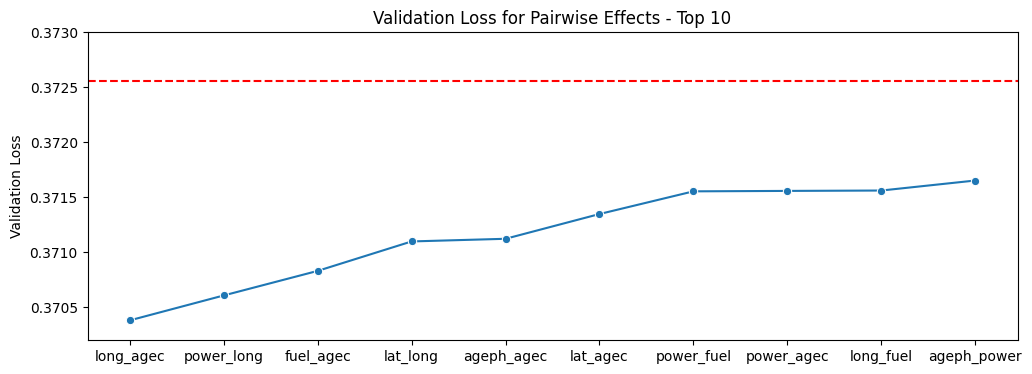

In [28]:
# -------------------------- plot the validation loss --------------------------
# Convert interaction loss dictionary to a pandas DataFrame
interaction_df = pd.DataFrame(list(interaction_loss.items()), columns = ['Interaction_Pair', 'Validation_Loss'])

# Sort the DataFrame by Validation_Loss in increasing order
interaction_df = interaction_df.sort_values(by = 'Validation_Loss', ascending = True)
interaction_df = interaction_df.head(10) # select the top 10 effects

# Create the bar plot using Seaborn
plt.rcParams["figure.figsize"] = (12, 4)
sns.lineplot(x = 'Interaction_Pair', y = 'Validation_Loss', data = interaction_df, marker = 'o')
plt.axhline(main_val_loss, color = 'red', linestyle = '--')
plt.xlabel('')
plt.ylabel('Validation Loss')
plt.title('Validation Loss for Pairwise Effects - Top 10')
# plt.legend()

# plt.rcParams["figure.dpi"] = 350
# plt.rcParams["savefig.bbox"] = "tight"
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["axes.spines.right"] = False
# plt.rcParams["axes.spines.top"] = False

plt.ylim(0.3702, 0.373)

plt.show()

In [61]:
# -------------------------- define model architecture --------------------------
def build_NAMLSS_zeroPoisson(hp):
    
    """
    The model has two branches:
      - Lambda (λ) branch: predicts the Poisson mean based on all covariates including the exposure.
      - Zero-inflation branch: predicts the probability (π) of zero.
    """
    # -------------------- hyperpameters --------------------
    smooth_vars         = ["ageph","bm","power","lat","long","agec"] # variables with smoothness constraint
    interactions        = [("long", "agec"), ("power", "long"), ("fuel", "agec"), ("lat", "long"), ("ageph", "agec")]
    inputs              = [] # to store input layers
    lambda_sub_outputs  = [] # for lambda branch
    pi_sub_outputs      = [] # for pi branch
    lattice_sizes       = {} # number of vertices for each variable's lattice
    activation          = "leaky_relu"
    monotone_lambda     = {"bm": "increasing", "expo": "increasing"} # monotonicity with lambda
    monotone_pi         = {"bm": "decreasing", "expo": "decreasing"} # monotonicity with pi
    grid_length         = 1000 # for using finite differences with smoothness constraint
    
    # hyperparameters for tuning
    num_neurons_main        = hp.Int('num_neurons_main', 20, 100, step = 20) # number of neurons for main effects' subnets' hidden layers
    num_layers_main         = hp.Int('num_layers_main', 2, 6)               # number of hidden layers for main effects' subnets
    num_neurons_interaction = hp.Int('num_neurons_int', 20, 200, step = 20) # number of neurons for interaction effects' subnets' hidden layers
    num_layers_interaction  = hp.Int('num_layers_int', 2, 10, step = 2)     # number of hidden layers for interaction effects' subnets
    num_keypoints           = hp.Int("num_keypoints", 20, 100, step = 20)    # number of key points for lattice calibrator
    num_vertices            = hp.Int("num_vertices", 2, 30, step = 4)       # number of vertices for lattice layer
    lambda_mc               = hp.Float('lambd_mc', 1e-6, 1e-2, sampling = 'log') # marginal clarity constraint for lambda
    pi_mc                   = hp.Float('pi_mc', 1e-6, 1e-2, sampling = 'log') # marginal clarity constraint for pi
    smooth_reg              = hp.Float('smoothness_reg', min_value = 1e-6, max_value = 1e-1, sampling = 'log') # weight for smoothness constraint in objective function
    
    # lattice size
    for v in imp_vars:
        lattice_sizes[v] = X_train[v].nunique() if v in cat_vars else num_vertices


    # -------------------- Lambda Branch - Main effects --------------------
    for name in ["expo"] + imp_vars:
        input_layer = Input(shape = (1,), name = name)
        inputs.append(input_layer)
        
        if name in cat_vars:
            embed_layer = Embedding(input_dim = X_train[name].nunique(), 
                                    output_dim = 1, 
                                    name = f"{name}_embed_lambda")(input_layer)
            embed_reshape = Reshape(target_shape = (1,), name = f"{name}_reshape_lambda")(embed_layer)
            effect = BatchNormalization(scale = False, name = f"{name}_effect_lambda")(embed_reshape)
            lambda_sub_outputs.append(effect)
        elif name in monotone_lambda:
            calibrator_layer = tfl.layers.PWLCalibration(
                    input_keypoints =  np.linspace(train[:,all_vars.index(name)].min(), 
                                                   train[:,all_vars.index(name)].max(), 
                                                   num = num_keypoints), # keypoints
                    monotonicity = monotone_lambda[name], # monotonicity constraint
                    name = f"{name}_pwlcalibrator_lambda"
            )(input_layer)
            mean_layer = BatchNormalization(scale = False, name = f"{name}_mean_lambda")(calibrator_layer)
            lambda_sub_outputs.append(mean_layer)    
        else:
            # For numeric variables, use a fully-connected subnet.
            subnet = create_subnet(num_layers_main, num_neurons_main, activation, f"{name}_subnetwork_lambda")
            effect = subnet(input_layer)
            lambda_sub_outputs.append(effect)
    

    # -------------------- Lambda Branch - Interaction effects --------------------
    for (var1, var2) in interactions:
        var1_input = inputs[imp_vars.index(var1) + 1]
        var2_input = inputs[imp_vars.index(var2) + 1]

        if any(var in monotone_lambda for var in [var1, var2]):
            lattice_inputs = []

            # calibrator layer
            calibrator_var1 = add_calibrate_layer(var1, var2, train, monotone_lambda, lattice_sizes, 
                                                  num_keypoints, cat_vars, all_vars)
            calibrator_var2 = add_calibrate_layer(var2, var1, train, monotone_lambda, lattice_sizes, 
                                                  num_keypoints, cat_vars, all_vars)
            calibrator_layer_var1 = calibrator_var1(var1_input)
            calibrator_layer_var2 = calibrator_var2(var2_input)
            
            # lattice layer
            lattice_inputs.append(calibrator_layer_var1)
            lattice_inputs.append(calibrator_layer_var2)
            lattice_layer = tfl.layers.Lattice(lattice_sizes = [lattice_sizes[var1], lattice_sizes[var2]], 
                                                monotonicities = [monotone_lambda[var1] if var1 in monotone_lambda else 'none',
                                                                monotone_lambda[var2] if var2 in monotone_lambda else 'none'],
                                                name = f"{var1}_{var2}_lattice_lambda")(lattice_inputs)
            pairwise_output = BatchNormalization(scale = False, name = f"{var1}_{var2}_mean_lambda")(lattice_layer)
            lambda_sub_outputs.append(pairwise_output)

        else: # if no monotonicity constraint is required, create a normal subnetwork
            pairwise_input_layer = Concatenate(name = f"{var1}_{var2}_concat_lambda")([var1_input, var2_input])
            pairwise_subnet = create_subnet(num_layers_interaction, 
                                            num_neurons_interaction, 
                                            activation, 
                                            f"{var1}_{var2}_subnetwork_lambda")
            pairwise_dense = pairwise_subnet(pairwise_input_layer)
            lambda_sub_outputs.append(pairwise_dense)
    

    # -------------------- combine main and interaction effects for Lambda --------------------
    main_concat = Concatenate(name = "subnet_output_lambda")(lambda_sub_outputs)
    final_lambda = AddSubnetOutput(activation = 'exponential', name = "lambda_output")(main_concat)


    # -------------------- Zero-Inflation Branch - Main effects --------------------
    for name in ["expo"] + imp_vars:
        if name == "expo":
            input_layer = inputs[0]
        else:
            input_layer = inputs[imp_vars.index(name) + 1]
        
        if name in cat_vars:
            embed_layer = Embedding(input_dim = X_train[name].nunique(), 
                                    output_dim = 1, 
                                    name = f"{name}_embed_pi")(input_layer)
            embed_reshape = Reshape(target_shape = (1,), name = f"{name}_reshape_pi")(embed_layer)
            effect = BatchNormalization(scale = False, name = f"{name}_effect_pi")(embed_reshape)
            pi_sub_outputs.append(effect)
        elif name in monotone_pi:
            calibrator_layer = tfl.layers.PWLCalibration(
                    input_keypoints =  np.linspace(train[:,all_vars.index(name)].min(), 
                                                   train[:,all_vars.index(name)].max(), 
                                                   num = num_keypoints), # keypoints
                    monotonicity = monotone_pi[name], # monotonicity constraint
                    name = f"{name}_pwlcalibrator_pi"
            )(input_layer)
            mean_layer = BatchNormalization(scale = False, name = f"{name}_mean_pi")(calibrator_layer)
            pi_sub_outputs.append(mean_layer)    
        else:
            # For numeric variables, use a fully-connected subnet.
            subnet = create_subnet(num_layers_main, num_neurons_main, activation, f"{name}_subnetwork_pi")
            effect = subnet(input_layer)
            pi_sub_outputs.append(effect)


    # -------------------- Zero-Inflation Branch - Interaction effects --------------------
    for (var1, var2) in interactions:
        var1_input = inputs[imp_vars.index(var1) + 1]
        var2_input = inputs[imp_vars.index(var2) + 1]

        if any(var in monotone_pi for var in [var1, var2]):
            lattice_inputs = []

            # calibrator layer
            calibrator_var1 = add_calibrate_layer(var1, var2, train, monotone_pi, lattice_sizes, 
                                                  num_keypoints, cat_vars, all_vars)
            calibrator_var2 = add_calibrate_layer(var2, var1, train, monotone_pi, lattice_sizes, 
                                                  num_keypoints, cat_vars, all_vars)
            calibrator_layer_var1 = calibrator_var1(var1_input)
            calibrator_layer_var2 = calibrator_var2(var2_input)
            
            # lattice layer
            lattice_inputs.append(calibrator_layer_var1)
            lattice_inputs.append(calibrator_layer_var2)
            lattice_layer = tfl.layers.Lattice(lattice_sizes = [lattice_sizes[var1], lattice_sizes[var2]], 
                                                monotonicities = [monotone_pi[var1] if var1 in monotone_pi else 'none',
                                                                monotone_pi[var2] if var2 in monotone_pi else 'none'],
                                                name = f"{var1}_{var2}_lattice_pi")(lattice_inputs)
            pairwise_output = BatchNormalization(scale = False, name = f"{var1}_{var2}_mean_pi")(lattice_layer)
            pi_sub_outputs.append(pairwise_output)

        else: # if no monotonicity constraint is required, create a normal subnetwork
            pairwise_input_layer = Concatenate(name = f"{var1}_{var2}_concat_pi")([var1_input, var2_input])
            pairwise_subnet = create_subnet(num_layers_interaction, 
                                            num_neurons_interaction, 
                                            activation, 
                                            f"{var1}_{var2}_subnetwork_pi")
            pairwise_dense = pairwise_subnet(pairwise_input_layer)
            pi_sub_outputs.append(pairwise_dense)
    

    # -------------------- combine main and interaction effects --------------------
    main_concat = Concatenate(name = "subnet_output_pi")(pi_sub_outputs)
    final_pi = AddSubnetOutput(activation = 'sigmoid', name = "pi_output")(main_concat)
    

    # -------------------- final model output --------------------
    # Concatenate λ and π to obtain a two-column output.
    final_output = Concatenate(name = "final_concatenation")([final_lambda, final_pi])
    model = Model(inputs = inputs, outputs = final_output)


    #-------------------------- add smoothness penalty --------------------------
    for var in smooth_vars:
        penalty_function = make_smoothness_penalty(var, train, model, smooth_reg, grid_length, ["expo"] + imp_vars, all_vars)
        model.add_loss(penalty_function)


    #-------------------------- add marginal clarity constraint --------------------------
    for i in range(len(interactions)):
        penalty = 0
        var1 = interactions[i][0]
        var2 = interactions[i][1]

        # for Lambda branch
        subnet_output_lambda    = model.get_layer("subnet_output_lambda").output
        main_output_var1_lambda = subnet_output_lambda[imp_vars.index(var1) + 1]
        main_output_var2_lambda = subnet_output_lambda[imp_vars.index(var2) + 1]
        interaction_output      = subnet_output_lambda[len(imp_vars) + i + 1]
        penalty = lambda_mc * (
            K.abs(K.mean(main_output_var1_lambda * interaction_output)) +
            K.abs(K.mean(main_output_var2_lambda * interaction_output))
        )

        # for Pi branch
        subnet_output_pi    = model.get_layer("subnet_output_pi").output
        main_output_var1_pi = subnet_output_pi[imp_vars.index(var1) + 1]
        main_output_var2_pi = subnet_output_pi[imp_vars.index(var2) + 1]
        interaction_output  = subnet_output_pi[len(imp_vars) + i + 1]
        penalty = pi_mc * (
            K.abs(K.mean(main_output_var1_pi * interaction_output)) +
            K.abs(K.mean(main_output_var2_pi * interaction_output))
        )

        # Add the penalty to the model's total loss
        model.add_loss(penalty)
    
    model.compile(optimizer = "rmsprop", 
                  loss = zip_loss, 
                  metrics = [zip_loss,RootMeanSquaredError(), MeanAbsoluteError()])
    return model

In [62]:
# -------------------------- Hyperparameter Tuning --------------------------
tuner_NAMLSS = kt.tuners.BayesianOptimization(
    build_NAMLSS_zeroPoisson,
    objective = kt.Objective('val_loss', direction = 'min'),
    max_trials = 100,
    directory = "hyperparameter_beMTPL97_NAMLSS_ZIP_100",
    seed = 2025  # for reproducibility
)

# regularization
es = EarlyStopping(patience = 60, restore_best_weights = True)

# search for the best model
tuner_NAMLSS.search(X_train_split, y_train,
                 epochs = 5_000,
                 batch_size = 10_000,
                 validation_data = (X_val_split, y_val),
                 callbacks = [es])

model_namlss = tuner_NAMLSS.get_best_models()[0]
tuner_NAMLSS.results_summary(1)

Reloading Tuner from hyperparameter_beMTPL97_NAMLSS_ZIP_100/untitled_project/tuner0.json
Results summary
Results in hyperparameter_beMTPL97_NAMLSS_ZIP_100/untitled_project
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 097 summary
Hyperparameters:
num_neurons_main: 80
num_layers_main: 5
num_neurons_int: 20
num_layers_int: 10
num_keypoints: 20
num_vertices: 2
lambd_mc: 0.003768844187850193
pi_mc: 0.01
smoothness_reg: 1.3344599755758933e-06
Score: 0.38700851798057556


In [63]:
#-------------------------- evaluate predictive performance --------------------------
_, namlss_nll, _, _ = model_namlss.evaluate(X_test_split, y_test, batch_size = 5_000)

# compute the predicted mean
preds = model_namlss.predict(X_test_split, batch_size = 5000)
lambd_ = preds[:,0]
pi_ = preds[:,1]
y_pred = (1 - pi_)*lambd_

# calculate the crps, rmse, and mae
namlss_crps = zip_crps(y_test, preds).numpy()
namlss_rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
namlss_mae  = np.mean(np.abs(y_test - y_pred))

# print
print(f"NLL on test set: {namlss_nll:.4f}")
print(f"CRPS on test set: {namlss_crps:.4f}")
print(f"RMSE on test set: {namlss_rmse:.4f}")
print(f"MAE on test set: {namlss_mae:.4f}")

7/7 [==============================] - 1s 9ms/step
NLL on test set: 0.3977
CRPS on test set: 0.1137
RMSE on test set: 0.3718
MAE on test set: 0.2195


32/32 [==============================] - 0s 2ms/step


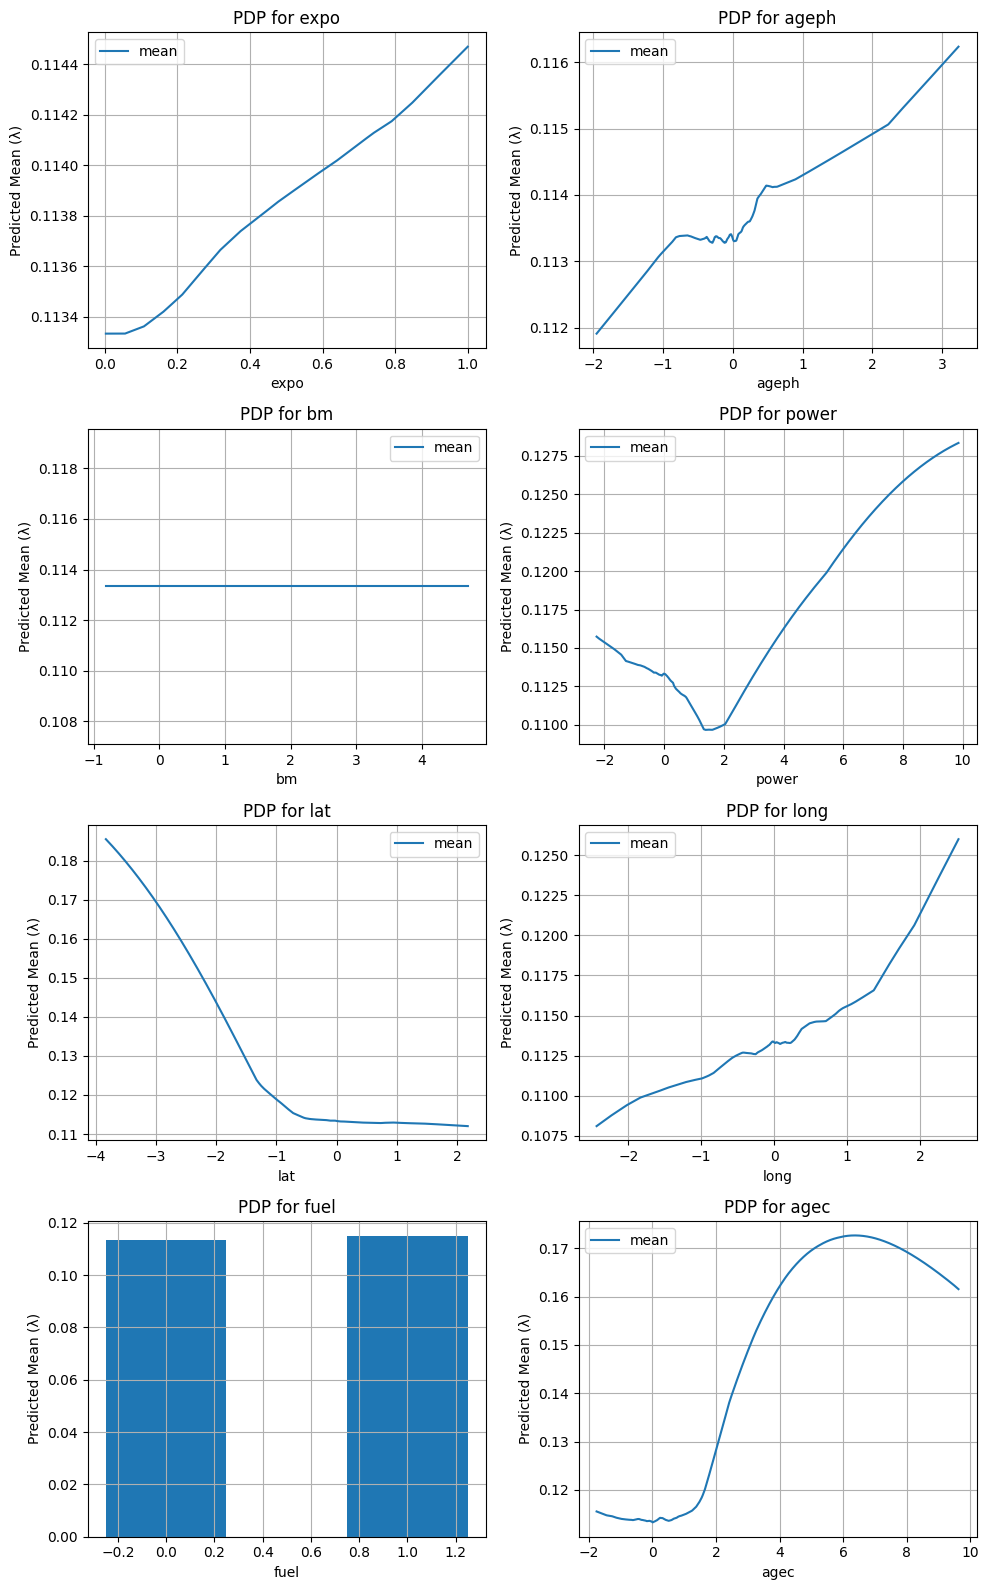

In [64]:
#-------------------------- view the PDP --------------------------
# Settings for grid
grid_length = 1000

# Define the list of main variables, including exposure
main_vars = ["expo"] + imp_vars

# Determine subplot grid layout based on the number of main variables
n_plots = len(main_vars)
ncols = 2
nrows = math.ceil(n_plots / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))
axes = axes.flatten()

# Loop over each main variable
for i, var_name in enumerate(main_vars):
    # Determine the index in X_train_split.
    # "expo" is at index 0; for others, index = imp_vars.index(var_name) + 1.
    if var_name == "expo":
        col_idx = 0
    else:
        col_idx = imp_vars.index(var_name) + 1

    # If the variable is categorical, use its unique values;
    # otherwise, create a continuous grid.
    if var_name in cat_vars:
        grid = np.sort(np.unique(X_train_split[col_idx]))
        n_points = grid.shape[0]
    else:
        grid = np.linspace(np.min(X_train_split[col_idx]),
                           np.max(X_train_split[col_idx]),
                           grid_length)
        n_points = grid_length

    # Build grid_inputs in the order: first "expo", then all variables in imp_vars.
    # For the current variable, use the grid; for others, use zeros (or reference values if desired).
    grid_inputs = []
    for var in main_vars:
        if var == var_name:
            if var in cat_vars:
                grid_inputs.append(grid.reshape(-1, 1).astype(np.int32))
            else:
                grid_inputs.append(grid.reshape(-1, 1).astype(np.float32))
        else:
            # For other variables, if they are categorical, use zeros of int type;
            # if numeric, use zeros of float type.
            if var in cat_vars:
                grid_inputs.append(np.zeros((n_points, 1), dtype=np.int32))
            else:
                grid_inputs.append(np.zeros((n_points, 1), dtype=np.float32))
    
    # Get predictions from the lambda and pi submodels.
    lam = model_namlss.predict(grid_inputs)[:,0]
    pi = model_namlss.predict(grid_inputs)[:,1]
    mean_pred = (1 - pi) * lam # predicted mean
    var_pred = (1 - pi) * lam * (1 + pi * lam)

    # plot the mean
    ax = axes[i]
    if var_name in cat_vars:
        # Mean bar
        ax.bar(grid, mean_pred, width = 0.5, align = 'center', label = 'mean')
    else:
        sns.lineplot(x = grid, y = mean_pred, ax = ax, label = 'mean')
    ax.set_xlabel(var_name)
    ax.set_ylabel("Predicted Mean (λ)")
    ax.set_title(f"PDP for {var_name}")
    ax.grid(True)


# Remove any extra subplots.
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

32/32 [==============================] - 0s 2ms/step


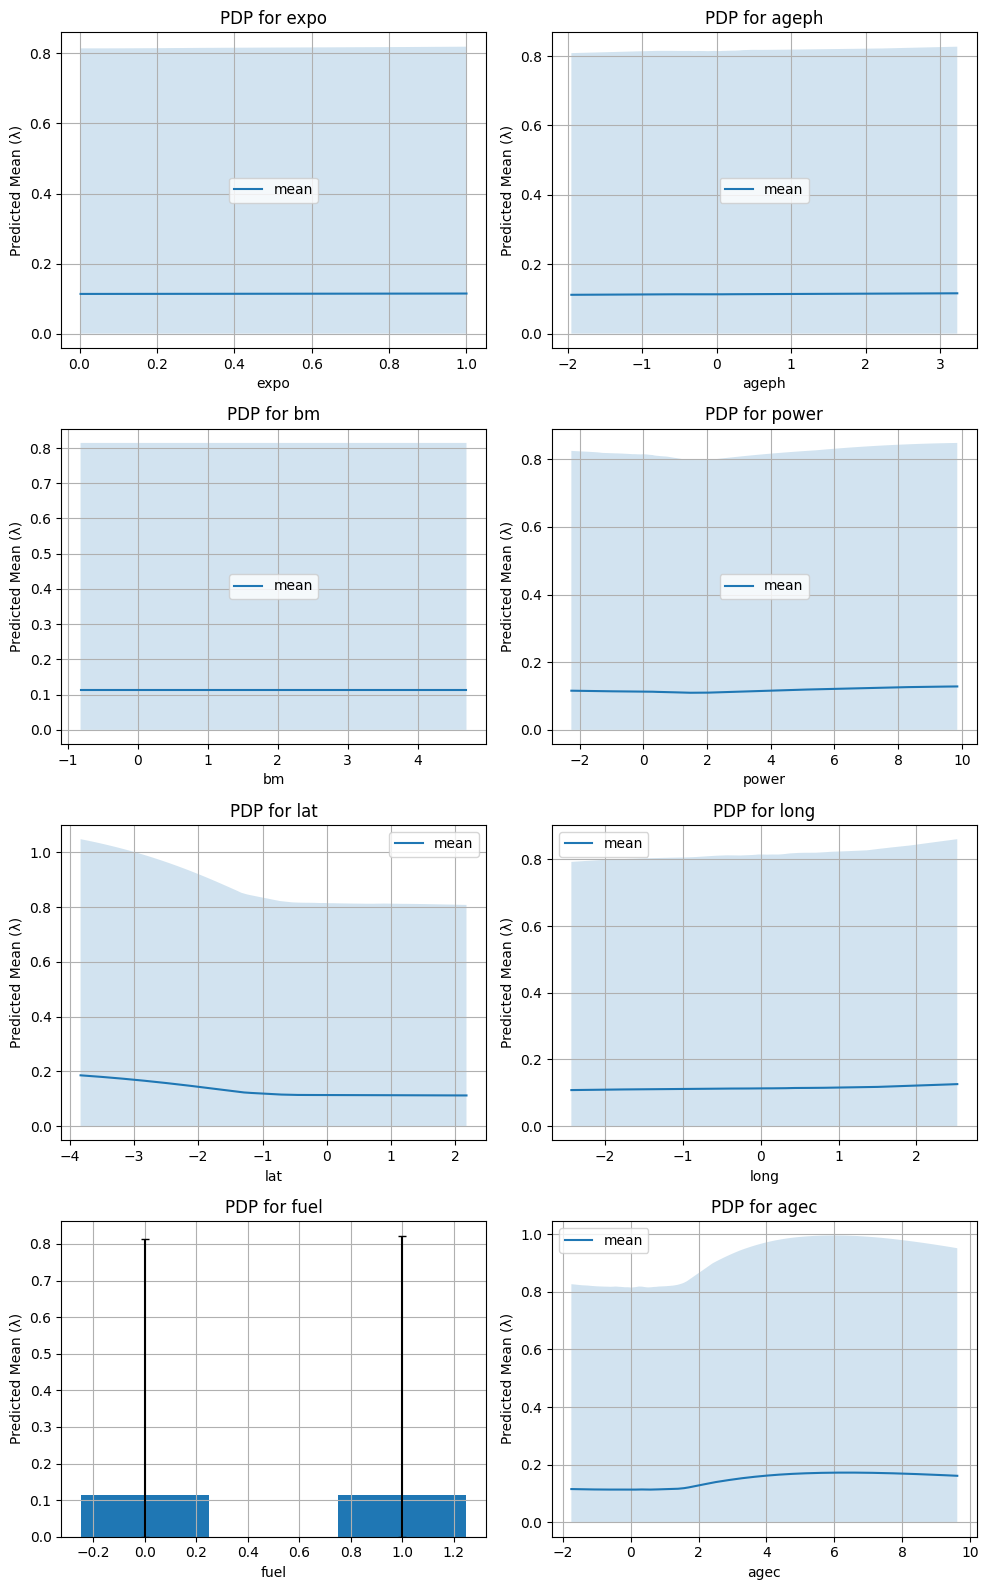

In [65]:
#-------------------------- view the shape function with prediction interval --------------------------
# Settings for grid
grid_length = 1000

# Define the list of main variables, including exposure
main_vars = ["expo"] + imp_vars

# Determine subplot grid layout based on the number of main variables
n_plots = len(main_vars)
ncols = 2
nrows = math.ceil(n_plots / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))
axes = axes.flatten()

# Loop over each main variable
for i, var_name in enumerate(main_vars):
    # Determine the index in X_train_split.
    # "expo" is at index 0; for others, index = imp_vars.index(var_name) + 1.
    if var_name == "expo":
        col_idx = 0
    else:
        col_idx = imp_vars.index(var_name) + 1

    # If the variable is categorical, use its unique values;
    # otherwise, create a continuous grid.
    if var_name in cat_vars:
        grid = np.sort(np.unique(X_train_split[col_idx]))
        n_points = grid.shape[0]
    else:
        grid = np.linspace(np.min(X_train_split[col_idx]),
                           np.max(X_train_split[col_idx]),
                           grid_length)
        n_points = grid_length

    # Build grid_inputs in the order: first "expo", then all variables in imp_vars.
    # For the current variable, use the grid; for others, use zeros (or reference values if desired).
    grid_inputs = []
    for var in main_vars:
        if var == var_name:
            if var in cat_vars:
                grid_inputs.append(grid.reshape(-1, 1).astype(np.int32))
            else:
                grid_inputs.append(grid.reshape(-1, 1).astype(np.float32))
        else:
            # For other variables, if they are categorical, use zeros of int type;
            # if numeric, use zeros of float type.
            if var in cat_vars:
                grid_inputs.append(np.zeros((n_points, 1), dtype=np.int32))
            else:
                grid_inputs.append(np.zeros((n_points, 1), dtype=np.float32))
    
    # Get predictions from the lambda and pi submodels.
    lam = model_namlss.predict(grid_inputs)[:,0]
    pi = model_namlss.predict(grid_inputs)[:,1]
    mean_pred = (1 - pi) * lam # predicted mean
    var_pred = (1 - pi) * lam * (1 + pi * lam)
    
    # compute 95% PI
    lo95 = np.clip(mean_pred - 1.96*np.sqrt(var_pred), 0, None)
    hi95 = mean_pred + 1.96*np.sqrt(var_pred)

    # plot the mean
    ax = axes[i]
    if var_name in cat_vars:
        # Mean bar + 95 % PI error bars
        ax.bar(grid, mean_pred, width = 0.5, align = 'center', label = 'mean')
        ax.errorbar(grid,
                    mean_pred,
                    yerr = [mean_pred - lo95, hi95 - mean_pred],
                    fmt = 'none',
                    ecolor = 'black',
                    capsize = 3,
                    label = '95 % PI')
    else:
        sns.lineplot(x = grid, y = mean_pred, ax = ax, label = 'mean')
        ax.fill_between(grid, lo95, hi95, alpha = 0.2, label = '95 % PI')
    ax.set_xlabel(var_name)
    ax.set_ylabel("Predicted Mean (λ)")
    ax.set_title(f"PDP for {var_name}")
    ax.grid(True)

# Remove any extra subplots.
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

32/32 [==============================] - 0s 1ms/step


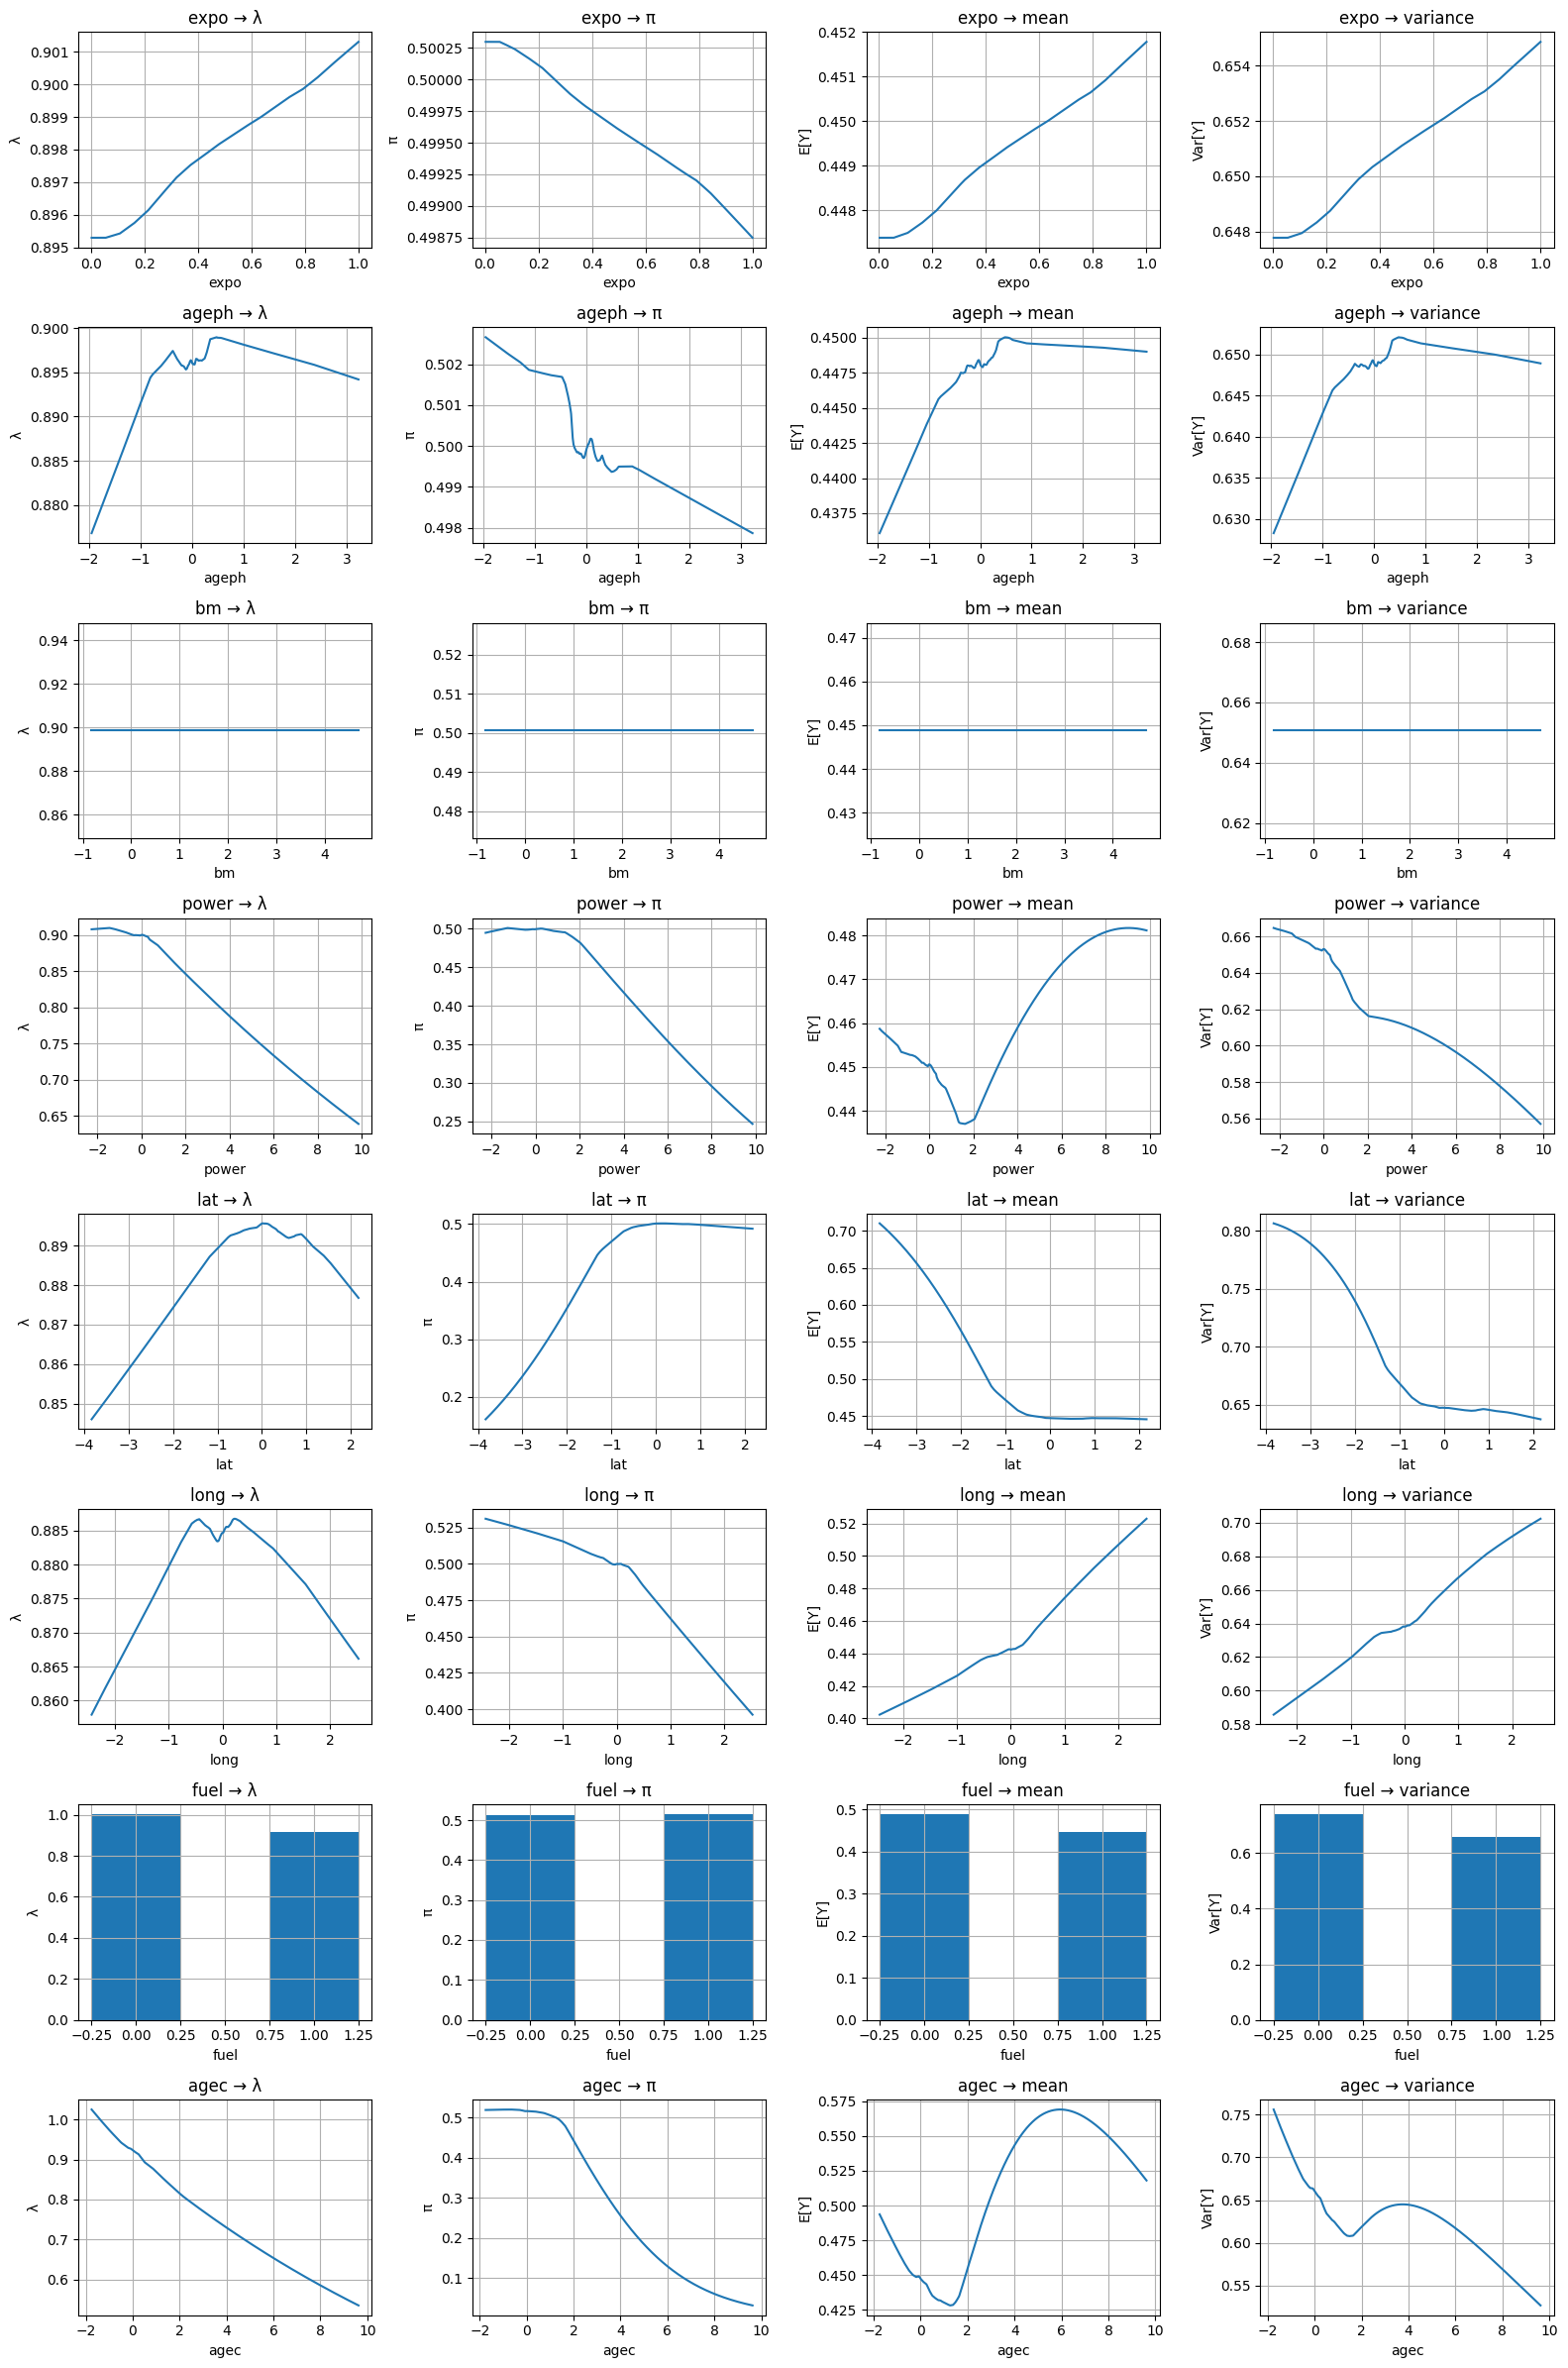

In [70]:
#-------------------------- view the shape function --------------------------
# Settings for grid
grid_length = 1000

# Define the model
subnet_output_lambda = model_namlss.get_layer(f"subnet_output_lambda")
subnet_output_pi = model_namlss.get_layer(f"subnet_output_pi")
subnet_lambda = Model(inputs = model_namlss.inputs, outputs = subnet_output_lambda.output)
subnet_pi = Model(inputs = model_namlss.inputs, outputs = subnet_output_pi.output)

# Define the list of main variables, including exposure
main_vars = ["expo"] + imp_vars

# Determine subplot grid layout based on the number of main variables
ncols = 4 # λ, π, mean, variance
nrows = len(main_vars) # one row per variable
fig, axes = plt.subplots(
    nrows, ncols,
    figsize = (4 * ncols, 3 * nrows), 
    squeeze = False
)

# Loop over each main variable
for i, var_name in enumerate(main_vars):
    # Determine the index in X_train_split.
    # "expo" is at index 0; for others, index = imp_vars.index(var_name) + 1.
    if var_name == "expo":
        col_idx = 0
    else:
        col_idx = imp_vars.index(var_name) + 1

    # If the variable is categorical, use its unique values;
    # otherwise, create a continuous grid.
    if var_name in cat_vars:
        grid = np.sort(np.unique(X_train_split[col_idx]))
        n_points = grid.shape[0]
    else:
        grid = np.linspace(np.min(X_train_split[col_idx]),
                           np.max(X_train_split[col_idx]),
                           grid_length)
        n_points = grid_length

    # Build grid_inputs in the order: first "expo", then all variables in imp_vars.
    # For the current variable, use the grid; for others, use zeros (or reference values if desired).
    grid_inputs = []
    for var in main_vars:
        if var == var_name:
            if var in cat_vars:
                grid_inputs.append(grid.reshape(-1, 1).astype(np.int32))
            else:
                grid_inputs.append(grid.reshape(-1, 1).astype(np.float32))
        else:
            # For other variables, if they are categorical, use zeros of int type;
            # if numeric, use zeros of float type.
            if var in cat_vars:
                grid_inputs.append(np.zeros((n_points, 1), dtype=np.int32))
            else:
                grid_inputs.append(np.zeros((n_points, 1), dtype=np.float32))
    
    # Get predictions from the model
    lam = np.exp(subnet_lambda.predict(grid_inputs)[:,col_idx])
    pi = 1/(1 + np.exp(-subnet_pi.predict(grid_inputs)[:,col_idx]))
    mean_pred = (1 - pi) * lam # predicted mean
    var_pred = (1 - pi) * lam * (1 + pi * lam)

    # -------------------------------- Plot --------------------------------
    # ---------- lambda ----------
    ax_lambda = axes[i][0]
    if var_name in cat_vars:
        ax_lambda.bar(grid, lam, width = 0.5, align = 'center')
    else:
        sns.lineplot(x = grid, y = lam.squeeze(), ax = ax_lambda)
    ax_lambda.set_title(f"{var_name} → λ")
    ax_lambda.set_xlabel(var_name)
    ax_lambda.set_ylabel("λ")
    ax_lambda.grid(True)

    # ---------- pi ----------
    ax_pi = axes[i][1]
    if var_name in cat_vars:
        ax_pi.bar(grid, pi, width = 0.5, align = 'center')
    else:
        sns.lineplot(x = grid, y = pi.squeeze(), ax = ax_pi)
    ax_pi.set_title(f"{var_name} → π")
    ax_pi.set_xlabel(var_name)
    ax_pi.set_ylabel("π")
    ax_pi.grid(True)

    # ---------- mean ----------
    ax_mean = axes[i][2]
    if var_name in cat_vars:
        ax_mean.bar(grid, mean_pred, width=0.5, align='center')
    else:
        sns.lineplot(x=grid, y=mean_pred.squeeze(), ax=ax_mean)
    ax_mean.set_title(f"{var_name} → mean")
    ax_mean.set_xlabel(var_name)
    ax_mean.set_ylabel("E[Y]")
    ax_mean.grid(True)

    # ---------- variance ----------
    ax_var = axes[i][3]
    if var_name in cat_vars:
        ax_var.bar(grid, var_pred, width=0.5, align='center')
    else:
        sns.lineplot(x=grid, y=var_pred.squeeze(), ax=ax_var)
    ax_var.set_title(f"{var_name} → variance")
    ax_var.set_xlabel(var_name)
    ax_var.set_ylabel("Var[Y]")
    ax_var.grid(True)


# Remove any extra subplots.
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

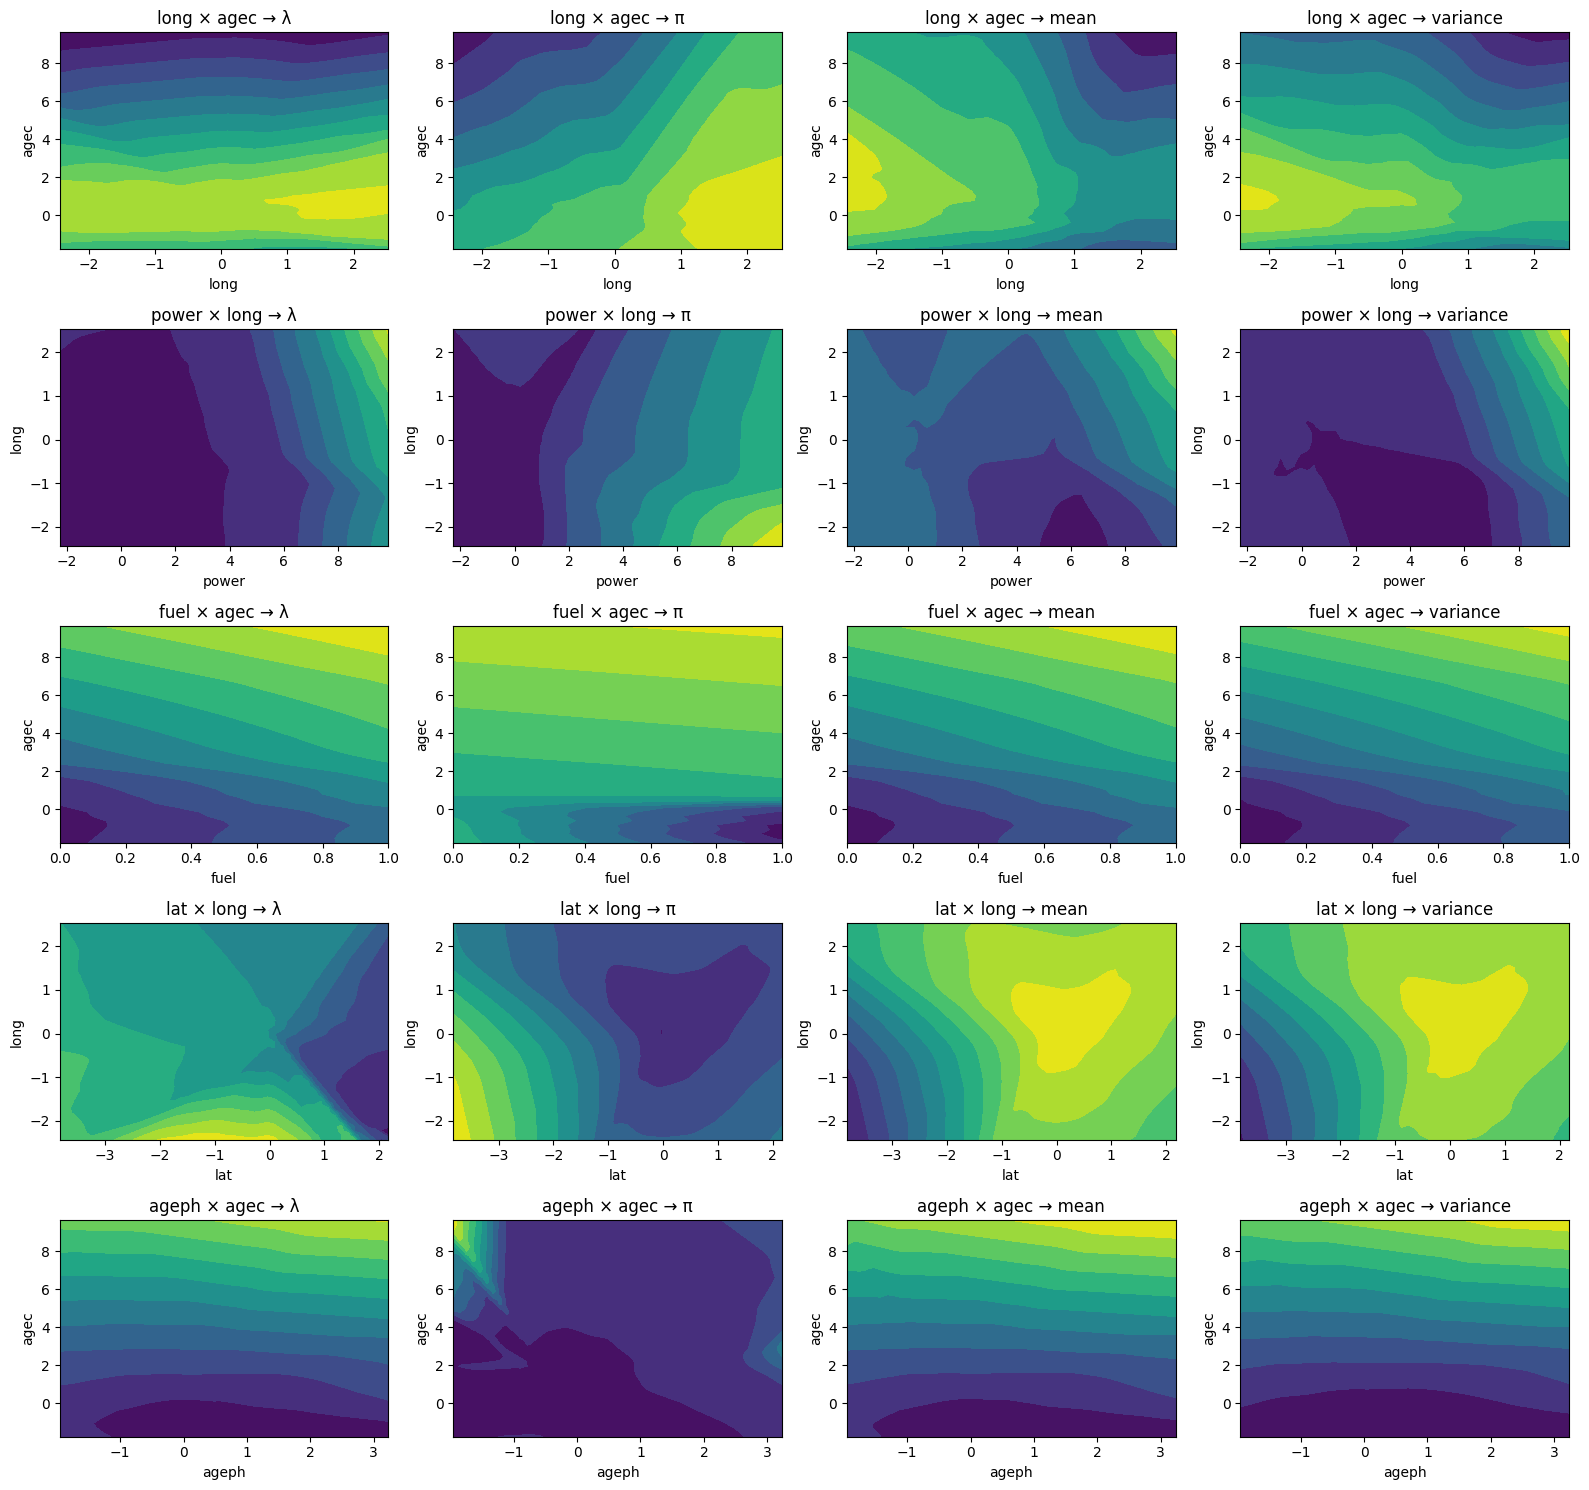

In [86]:
# -------------------- view pair-wise interaction heat-maps --------------------
# configure plot area
interactions = [("long", "agec"), ("power", "long"), ("fuel", "agec"), ("lat", "long"), ("ageph", "agec")]
grid_len_num = 50
ncols_int    = 4
nrows_int    = len(interactions)
fig_int, axes_int = plt.subplots(
    nrows_int, ncols_int,
    figsize=(4 * ncols_int, 3 * nrows_int),
    squeeze = False
)

for i, (var1, var2) in enumerate(interactions):

    # ---------- 1. build a 2-D grid over var1 × var2 ----------
    def _make_axis(v, is_mesh=False):
        """Return 1-D grid for a variable and dtype."""
        if v in cat_vars:
            axis = np.sort(np.unique(X_train_split[imp_vars.index(v) + 1]))
            dtype = np.int32
        else:
            lo  = np.min(X_train_split[imp_vars.index(v) + 1])
            hi  = np.max(X_train_split[imp_vars.index(v) + 1])
            axis = np.linspace(lo, hi, grid_len_num)
            dtype = np.float32
        return axis.astype(dtype)

    axis1 = _make_axis(var1)
    axis2 = _make_axis(var2)
    mesh1, mesh2 = np.meshgrid(axis1, axis2, indexing="xy")
    n_mesh = mesh1.size

    # ---------- 2. assemble model inputs ----------
    mesh_inputs = []
    for v in main_vars:
        if v == var1:
            mesh_inputs.append(mesh1.reshape(-1, 1).astype(axis1.dtype))
        elif v == var2:
            mesh_inputs.append(mesh2.reshape(-1, 1).astype(axis2.dtype))
        else:
            dtype = np.int32 if v in cat_vars else np.float32
            mesh_inputs.append(np.zeros((n_mesh, 1), dtype=dtype))

    # ---------- 3. pick out the interaction column ----------
    inter_col = len(main_vars) + i
    lam_int   = np.exp(subnet_lambda.predict(mesh_inputs, verbose = 0)[:, inter_col])
    pi_int    = 1/(1 + np.exp(-subnet_pi.predict(mesh_inputs, verbose = 0)[:, inter_col]))
    mean_int  = (1.0 - pi_int) * lam_int
    var_int   = (1.0 - pi_int) * lam_int * (1.0 + pi_int * lam_int)

    # reshape to 2-D for heat-maps
    lam_mat, pi_mat = lam_int.reshape(mesh1.shape), pi_int.reshape(mesh1.shape)
    mean_mat, var_mat = mean_int.reshape(mesh1.shape), var_int.reshape(mesh1.shape)

    # ---------- 4. plot the four contour heat-maps ----------
    for j, (mat, title) in enumerate([
        (lam_mat,  "λ"),
        (pi_mat,   "π"),
        (mean_mat, "mean"),
        (var_mat,  "variance")
    ]):
        ax = axes_int[i][j]

        # filled-contour on *this* axis
        contour = ax.contourf(
            axis1, axis2,               # 1-D X and Y
            mat,                        # 2-D Z  (shape len(axis2) × len(axis1))
            levels = 10,
            cmap = "viridis"
        )

        # axis labels & title
        ax.set_xlabel(var1)
        ax.set_ylabel(var2)
        ax.set_title(f"{var1} × {var2} → {title}")

plt.tight_layout()
plt.show()
